In [1]:
# !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
# !tar xzvf food-101.tar.gz

In [2]:
import tensorflow as tf

tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import os
from glob import glob
from time import time
from itertools import chain

from tqdm.keras import TqdmCallback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    VGG16, 
    ResNet50, ResNet50V2, 
    MobileNet, MobileNetV2, 
    EfficientNetB0, EfficientNetB1, EfficientNetB2
)
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics

from sklearn.metrics import confusion_matrix, classification_report
import mlflow
import mlflow.tensorflow

mlflow.set_tracking_uri("sqlite:///ml_training_logs/mlflow.db")
mlflow.set_experiment("LiveProjectDeployCViOS")

np.random.seed(42)

foods = !ls food-101/images
foods = np.random.choice(foods, size=5, replace=False)

paths = [glob(f"food-101/images/{food}/*") for food in foods]
              
X = np.ravel([p for p in chain(paths)])
y = np.ravel([[i]*1000 for i in range(len(foods))])
food_label = np.ravel([[food]*1000 for food in foods])

set_type = np.random.choice(['train','test','validation'], len(X), replace=True, p=[0.7, 0.2, 0.1])

data_df = pd.DataFrame({'X':X, 'y':y, 'set':set_type, 'food_label':food_label})
data_df = pd.concat([data_df, pd.get_dummies(data_df['food_label'])], axis=1)

data_df

,X,y,set,food_label,frozen_yogurt,hot_dog,nachos,omelette,risotto
0,food-101/images/risotto/65321.jpg,0,train,risotto,0,0,0,0,1
1,food-101/images/risotto/200595.jpg,0,test,risotto,0,0,0,0,1
2,food-101/images/risotto/19112.jpg,0,test,risotto,0,0,0,0,1
3,food-101/images/risotto/94799.jpg,0,train,risotto,0,0,0,0,1
4,food-101/images/risotto/111461.jpg,0,validation,risotto,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
4995,food-101/images/frozen_yogurt/1283999.jpg,4,train,frozen_yogurt,1,0,0,0,0
4996,food-101/images/frozen_yogurt/610008.jpg,4,train,frozen_yogurt,1,0,0,0,0
4997,food-101/images/frozen_yogurt/2177517.jpg,4,train,frozen_yogurt,1,0,0,0,0
4998,food-101/images/frozen_yogurt/3802650.jpg,4,train,frozen_yogurt,1,0,0,0,0


In [4]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time() - self.epoch_time_start)

In [5]:
target_shape = (160, 160)

datagen = ImageDataGenerator(
    # featurewise_center=True,
    # featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=1.0/8,
    )


train_generator = datagen.flow_from_dataframe(
    data_df[data_df['set'] == 'train'],
    x_col='X',
    y_col='food_label',
    directory=None,
    target_size=(target_shape),
    class_mode='categorical',
    batch_size=16
)

test_generator = datagen.flow_from_dataframe(
    data_df[data_df['set'] == 'test'],
    x_col='X',
    y_col='food_label',
    directory=None,
    target_size=(target_shape),
    class_mode='categorical',
    batch_size=16
)

val_generator = datagen.flow_from_dataframe(
    data_df[data_df['set'] == 'validation'],
    x_col='X',
    y_col='food_label',
    directory=None,
    target_size=(target_shape),
    class_mode='categorical',
    batch_size=16
)

Found 3499 validated image filenames belonging to 5 classes.
Found 1036 validated image filenames belonging to 5 classes.
Found 465 validated image filenames belonging to 5 classes.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.



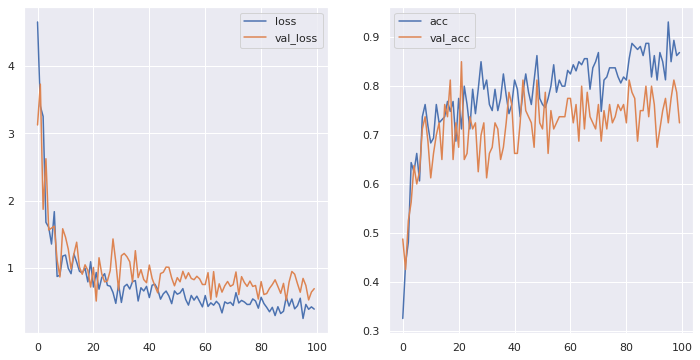

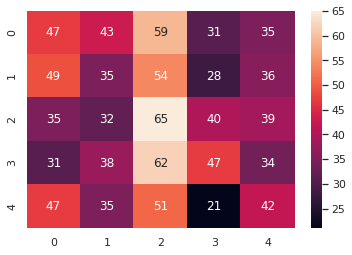

In [ ]:
base_models = [VGG16,ResNet50, ResNet50V2, MobileNet, MobileNetV2, EfficientNetB0, EfficientNetB1, EfficientNetB2]

params = {}
params['foods'] = foods


for base in base_models:
    initial_learning_rate = 1e-3
    decay_steps = 100
    decay_rate = 0.999
    
    params['base_model'] = base.__name__
    params['initial_learning_rate'] = initial_learning_rate
    params['decay_steps'] = 100
    params['decay_rate'] = 0.999
    
    conv_base = base(weights='imagenet', include_top=False, input_shape=[*target_shape, 3])
    conv_base.trainable = False
    
    with mlflow.start_run() as run:
        mlflow.tensorflow.autolog(every_n_iter=1)
        
        model = models.Sequential()
        model.add(conv_base)
        model.add(layers.GlobalAveragePooling2D())
        model.add(layers.Flatten())
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(len(foods), activation='softmax'))


        loss_fn = losses.CategoricalCrossentropy()

        lr_schedule = ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
        )
        
        optimizer = Adam(learning_rate=lr_schedule)


        model.compile(loss=loss_fn,
                      optimizer=optimizer,
                      metrics=['acc','mse'])

        time_callback = TimeHistory()

        history = model.fit(
            train_generator,
            steps_per_epoch=10,
            epochs=100,
            validation_data=val_generator,
            validation_steps=5,
            callbacks=[TqdmCallback(), time_callback],
            verbose=0,
        )

        num_trainable = sum([np.prod(tw.shape) for tw in model.trainable_weights])
        num_non_trainable = sum([np.prod(tw.shape) for tw in model.non_trainable_weights])
        total_wall_time = sum(time_callback.times)
        model_size = os.stat('model.h5').st_size / (1024**2)

        params['num_trainable'] = num_trainable
        params['num_non_trainable'] = num_non_trainable
        params['total_wall_time'] = total_wall_time
        params['model_size'] = model_size
        mlflow.log_params(params)
        
        
        fig, ax = plt.subplots(1,2, figsize=(12,6))

        hist_df = pd.DataFrame(history.history).reset_index()
        hist_df.plot(y=['loss','val_loss'], ax=ax[0])
        hist_df.plot(y=['acc','val_acc'], ax=ax[1])
        plt.savefig('acc_loss.png')
        mlflow.log_artifact('acc_loss.png')
        plt.show()



        y_pred = model.predict(test_generator)
        y_pred_food = np.argmax(y_pred, axis=1)
        sns.heatmap(confusion_matrix(test_generator.classes, y_pred_food), annot=True)

        plt.savefig('confusion_matrix.png')
        mlflow.log_artifact('confusion_matrix.png')
        plt.show()

        